# Graph Neural Network for Multi-Asset Market Modeling — Variant C 📈

This notebook implements a GNN + LSTM model for predicting the next-step direction of Asset A using multi-asset time series, incorporating **learnable attention** over a set of precomputed correlation windows.

### Features
- Candidate correlation windows: **30min, 1h, 2h, 4h**
- **NaN-safe** normalization and correlation calculation.
- **Multi-window attention** (softmax-weighted combination) for dynamic correlation weighting.
- Monitoring attention weights per epoch for **interpretability**.
- Synthetic dataset $T \approx 3000$.

In [16]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import pandas as pd
from pathlib import Path

In [17]:

# ============================================================
# 1. Synthetic dataset generation (3000 timesteps)
# ============================================================

T = 3000
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

price_A = np.cumsum(np.random.randn(T) * 0.01 + 1.3)
price_B = np.cumsum(np.random.randn(T) * 10 + 6e4)
price_C = np.cumsum(np.random.randn(T) * 2 + 2e3)

vol_A = np.random.lognormal(mean=7, sigma=1.0, size=T)
vol_B = np.random.lognormal(mean=10, sigma=1.5, size=T)
vol_C = np.random.lognormal(mean=8, sigma=1.2, size=T)

df = pd.DataFrame({
    "price_A": price_A, "vol_A": vol_A,
    "price_B": price_B, "vol_B": vol_B,
    "price_C": price_C, "vol_C": vol_C
})

df["lr_A"] = np.log(df["price_A"]).diff().fillna(0)
df["lr_B"] = np.log(df["price_B"]).diff().fillna(0)
df["lr_C"] = np.log(df["price_C"]).diff().fillna(0)
df["dir_A_next"] = (df["price_A"].shift(-1) > df["price_A"]).astype(int)

# ============================================================
# 2. Cleaning pipeline
# ============================================================

for col in ["vol_A", "vol_B", "vol_C"]:
    df[col] = df[col].clip(lower=1e-6)

def winsorize(series, q=0.995):
    low = series.quantile(1 - q)
    high = series.quantile(q)
    return series.clip(lower=low, upper=high)

for col in ["vol_A", "vol_B", "vol_C"]:
    df[col] = winsorize(df[col])

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.ffill(inplace=True)
df.bfill(inplace=True)

for col in ["price_A", "price_B", "price_C"]:
    df[col] = df[col].clip(lower=1e-8)

df["lr_A"] = np.log(df["price_A"]).diff().fillna(0)
df["lr_B"] = np.log(df["price_B"]).diff().fillna(0)
df["lr_C"] = np.log(df["price_C"]).diff().fillna(0)

for col in ["lr_A", "lr_B", "lr_C"]:
    df[col] = df[col].clip(lower=-0.2, upper=0.2)

print("\nSanitized data summary:")
print(df.describe())

# ============================================================
# 3. Multi-window correlations
# ============================================================

candidate_windows = [6, 12, 24, 48, 96]
n_w = len(candidate_windows)

edges = [("A", "B"), ("A", "C"), ("C", "B")]
n_edges = len(edges)

corr_array = np.zeros((T, n_edges, n_w), dtype=np.float32)

for wi, w in enumerate(candidate_windows):
    r_ab = df["lr_A"].rolling(w, min_periods=1).corr(df["lr_B"]).fillna(0)
    r_ac = df["lr_A"].rolling(w, min_periods=1).corr(df["lr_C"]).fillna(0)
    r_cb = df["lr_C"].rolling(w, min_periods=1).corr(df["lr_B"]).fillna(0)

    corr_array[:, 0, wi] = np.nan_to_num(r_ab)
    corr_array[:, 1, wi] = np.nan_to_num(r_ac)
    corr_array[:, 2, wi] = np.nan_to_num(r_cb)

print("corr_array shape:", corr_array.shape)



Sanitized data summary:
           price_A         vol_A       price_B         vol_B       price_C  \
count  3000.000000   3000.000000  3.000000e+03  3.000000e+03  3.000000e+03   
mean   1951.150049   1701.298826  9.002950e+07  6.740668e+04  3.000973e+06   
std    1126.391151   1881.160802  5.196987e+07  1.358812e+05  1.732339e+06   
min       1.304967     70.428043  5.998092e+04  5.410132e+02  1.997772e+03   
25%     975.833923    560.015041  4.504503e+07  8.336019e+03  1.501461e+06   
50%    1951.389635   1071.858029  9.002934e+07  2.329542e+04  3.000952e+06   
75%    2926.118806   2065.751060  1.350144e+08  6.340632e+04  4.500459e+06   
max    3900.960025  12658.256058  1.799989e+08  1.130740e+06  6.000019e+06   

              vol_C         lr_A         lr_B         lr_C   dir_A_next  
count   3000.000000  3000.000000  3000.000000  3000.000000  3000.000000  
mean    6056.583389     0.002398     0.002399     0.002399     0.999667  
std     8760.147872     0.010671     0.010682     

In [18]:

# ============================================================
# 4. Dataset 50/20/30 split
# ============================================================

class MarketDataset(Dataset):
    def __init__(self, df, corr_array, window=24, normalize=True):
        self.df = df.reset_index(drop=True)
        self.T = len(df)
        self.window = window
        self.corr_array = corr_array
        self.normalize = normalize

        prices = df[["price_A", "price_B", "price_C"]].values
        lv = np.log1p(df[["vol_A", "vol_B", "vol_C"]].values)

        self.p_mean = prices.mean(0)
        self.p_std = prices.std(0) + 1e-6
        self.v_mean = lv.mean(0)
        self.v_std = lv.std(0) + 1e-6

    def __len__(self):
        return self.T - self.window - 1

    def __getitem__(self, idx):
        X = []
        for t in range(idx, idx + self.window):
            r = self.df.iloc[t]
            price = np.array([r.price_A, r.price_B, r.price_C], dtype=np.float32)
            vol = np.log1p(np.array([r.vol_A, r.vol_B, r.vol_C], dtype=np.float32))

            if self.normalize:
                price = (price - self.p_mean) / self.p_std
                vol = (vol - self.v_mean) / self.v_std

            X.append(np.stack([price, vol], axis=1))

        y = int(self.df.iloc[idx + self.window].dir_A_next)
        corr_slice = self.corr_array[idx: idx + self.window]

        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long), torch.tensor(corr_slice, dtype=torch.float32)


window = 24
full_ds = MarketDataset(df, corr_array, window=window)

N = len(full_ds)
i_train = int(0.5 * N)
i_val = int(0.7 * N)

train_ds = torch.utils.data.Subset(full_ds, range(0, i_train))
val_ds = torch.utils.data.Subset(full_ds, range(i_train, i_val))
test_ds = torch.utils.data.Subset(full_ds, range(i_val, N))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

print(f"Dataset sizes → train={len(train_ds)}, val={len(val_ds)}, test={len(test_ds)}")


Dataset sizes → train=1487, val=595, test=893


In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# =====================================================================
# 1. Spatial GAT Layer (исправленная версия)
# =====================================================================
class SpatialGATLayer(nn.Module):
    def __init__(self, in_dim, out_dim, heads=2):
        super().__init__()
        self.heads = heads
        self.W = nn.Parameter(torch.randn(heads, in_dim, out_dim))
        self.a = nn.Parameter(torch.randn(heads, 2 * out_dim))
        self.leaky = nn.LeakyReLU(0.2)

    def forward(self, X, A):
        """
        X: (B,3,in_dim)
        A: (B,3,3)
        """
        B = X.size(0)
        H = self.heads
        out_dim = self.W.size(2)

        # (B,H,3,out_dim)
        XW = torch.einsum("bni,hio->bhno", X, self.W)

        # pairwise i,j — всё 4D, никаких 5D!
        Xi = XW.unsqueeze(3)              # (B,H,3,1,out_dim)
        Xj = XW.unsqueeze(2)              # (B,H,1,3,out_dim)

        concat = torch.cat([
            Xi.expand(-1,-1,-1,3,-1),
            Xj.expand(-1,-1,3,-1,-1)
        ], dim=-1)                        # (B,H,3,3,2*out_dim)

        e = self.leaky(torch.einsum("bhijd,hk->bhij", concat, self.a))

        mask = (A == 0).unsqueeze(1)      # (B,1,3,3)
        e = e.masked_fill(mask, -1e9)

        alpha = torch.softmax(e, dim=-1)  # (B,H,3,3)

        # ---- FIX: правильный message passing ----
        # XW_j: (B,H,3,out_dim) -> (B,H,3,1,out_dim)
        XW_exp = XW.unsqueeze(2)          # (B,H,1,3,out_dim)

        out = torch.einsum("bhij,bhjd->bhid", alpha, XW_exp.squeeze(2))
        # -----------------------------------------

        return out.mean(1)               # (B,3,out_dim)



# =====================================================================
# 2. Temporal Attention
# =====================================================================
class TemporalAttention(nn.Module):
    def __init__(self, dim, heads=4):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** 0.5

        self.Wq = nn.Linear(dim, dim)
        self.Wk = nn.Linear(dim, dim)
        self.Wv = nn.Linear(dim, dim)

    def forward(self, x):
        """
        x: (B,3,hidden)
        """
        B, T, D = x.shape
        H = self.heads
        Dh = D // H

        Q = self.Wq(x).reshape(B, T, H, Dh)
        K = self.Wk(x).reshape(B, T, H, Dh)
        V = self.Wv(x).reshape(B, T, H, Dh)

        att = torch.einsum("bthd,bshd->bhts", Q, K) / self.scale
        att = torch.softmax(att, dim=-1)

        out = torch.einsum("bhts,bshd->bthd", att, V)
        return out.reshape(B, T, D), att



# =====================================================================
# 3. Full TemporalGAT (исправленный)
# =====================================================================
class TemporalGAT(nn.Module):
    def __init__(self, node_feat_dim=2, hidden=32, n_w=5):
        super().__init__()
        self.spatial = SpatialGATLayer(node_feat_dim, hidden)
        self.temporal = TemporalAttention(hidden)
        self.fc = nn.Linear(hidden, 2)

        self.w_att = nn.Parameter(torch.randn(3, n_w))  # 3 edges

    def build_adj(self, e):
        """
        e: (B,3)
        returns: (B,3,3)
        """
        ab = e[:, 0]
        ac = e[:, 1]
        bc = e[:, 2]

        B = e.size(0)
        A = torch.zeros(B, 3, 3, device=e.device)

        A[:,0,1] = A[:,1,0] = ab
        A[:,0,2] = A[:,2,0] = ac
        A[:,1,2] = A[:,2,1] = bc
        A[:, range(3), range(3)] = 1.0

        return A

    def forward(self, X, corr_slice):
        """
        X: (B,T,3,2)
        corr_slice: (B,T,3,n_w)
        """
        B, T, _, _ = X.shape

        w = F.softmax(self.w_att, dim=-1)                  # (3,n_w)

        edges = torch.einsum("bt e w, e w -> b t e", corr_slice, w)   # (B,T,3)
        e_last = edges[:, -1, :]                           # (B,3)

        A = self.build_adj(e_last)                         # (B,3,3)

        X_last = X[:, -1, :, :]                            # (B,3,2)

        Hs = self.spatial(X_last, A)                       # (B,3,hidden)
        Ht, _ = self.temporal(Hs)                          # (B,3,hidden)

        H = Hs.mean(1) + Ht.mean(1)

        logits = self.fc(H)
        return logits, w, _


In [22]:

# ============================================================
# 6. Training loop
# ============================================================

device = "cuda" if torch.cuda.is_available() else "cpu"
model = TemporalGAT(node_feat_dim=2, hidden=32, n_w=5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 12

train_loss_hist = []
val_loss_hist = []
val_acc_hist = []

for epoch in range(n_epochs):
    model.train()
    total_loss = 0

    for X, y, corr in train_loader:
        X = X.to(device)
        y = y.to(device)
        corr = corr.to(device)

        optimizer.zero_grad()
        logits, _, _ = model(X, corr)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_loss_hist.append(total_loss / len(train_loader))

    model.eval()
    correct = 0
    total = 0
    val_loss = 0

    with torch.no_grad():
        for X, y, corr in val_loader:
            X = X.to(device)
            y = y.to(device)
            corr = corr.to(device)

            logits, _, _ = model(X, corr)
            loss = criterion(logits, y)
            val_loss += loss.item()

            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)

    val_loss_hist.append(val_loss / len(val_loader))
    val_acc = correct / total
    val_acc_hist.append(val_acc)

    print(f"Epoch {epoch+1}/{n_epochs} | TrainLoss={train_loss_hist[-1]:.4f} | ValLoss={val_loss_hist[-1]:.4f} | ValAcc={val_acc:.4f}")


Epoch 1/12 | TrainLoss=0.1325 | ValLoss=0.5944 | ValAcc=0.6655
Epoch 2/12 | TrainLoss=0.0355 | ValLoss=0.7812 | ValAcc=0.5731
Epoch 3/12 | TrainLoss=0.0236 | ValLoss=0.9627 | ValAcc=0.4975
Epoch 4/12 | TrainLoss=0.0168 | ValLoss=1.1317 | ValAcc=0.4689
Epoch 5/12 | TrainLoss=0.0128 | ValLoss=1.3278 | ValAcc=0.4353
Epoch 6/12 | TrainLoss=0.0102 | ValLoss=1.5029 | ValAcc=0.4202
Epoch 7/12 | TrainLoss=0.0080 | ValLoss=1.6746 | ValAcc=0.4017
Epoch 8/12 | TrainLoss=0.0067 | ValLoss=1.8149 | ValAcc=0.3950
Epoch 9/12 | TrainLoss=0.0058 | ValLoss=1.9241 | ValAcc=0.3933
Epoch 10/12 | TrainLoss=0.0045 | ValLoss=2.1608 | ValAcc=0.3681
Epoch 11/12 | TrainLoss=0.0038 | ValLoss=2.2696 | ValAcc=0.3630
Epoch 12/12 | TrainLoss=0.0033 | ValLoss=2.4254 | ValAcc=0.3563


In [23]:

# ============================================================
# 7. Test evaluation
# ============================================================

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for X, y, corr in test_loader:
        X = X.to(device)
        y = y.to(device)
        corr = corr.to(device)

        logits, _, _ = model(X, corr)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

test_acc = correct / total
print(f"\nFinal Test Accuracy: {test_acc:.4f}")



Final Test Accuracy: 0.0000


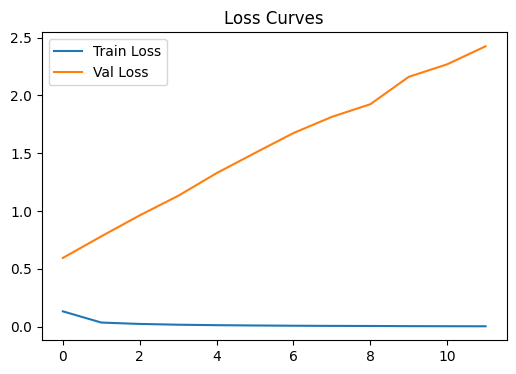

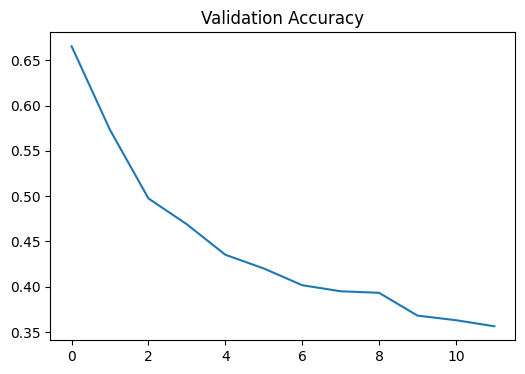


Done.


In [24]:

# ============================================================
# 8. Visualization
# ============================================================

plt.figure(figsize=(6,4))
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.legend()
plt.title("Loss Curves")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(val_acc_hist)
plt.title("Validation Accuracy")
plt.show()

print("\nDone.")
